In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# ==========================================
# 1. Persiapan Data (Fashion MNIST)
# ==========================================
# Memuat data beserta labelnya untuk keperluan visualisasi nanti
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalisasi data ke rentang [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Padding gambar dari 28x28 menjadi 32x32 agar lebih mudah di-downsample
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

# Menambahkan dimensi channel (N, 32, 32, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(f"Ukuran data train: {x_train.shape}")
print(f"Ukuran data test: {x_test.shape}")

Ukuran data train: (60000, 32, 32, 1)
Ukuran data test: (10000, 32, 32, 1)


In [ ]:
# ==========================================
# 2. Definisi Komponen VAE
# ==========================================

# -- Layer Sampling (Reparameterization Trick) --
class Sampling(layers.Layer):
    """Menggunakan (z_mean, z_log_var) untuk mensample z, vektor encoding."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# -- Encoder --
latent_dim = 2  # Dimensi latent space (2D agar mudah divisualisasikan)

encoder_inputs = keras.Input(shape=(32, 32, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# -- Decoder --
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# -- Model VAE Lengkap --
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Reconstruction Loss (Binary Crossentropy)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )

            # KL Divergence Loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# ==========================================
# 1. Persiapan Data (Fashion MNIST)
# ==========================================
# Memuat data beserta labelnya untuk keperluan visualisasi nanti
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalisasi data ke rentang [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Padding gambar dari 28x28 menjadi 32x32 agar lebih mudah di-downsample
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

# Menambahkan dimensi channel (N, 32, 32, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(f"Ukuran data train: {x_train.shape}")
print(f"Ukuran data test: {x_test.shape}")


# ==========================================
# 2. Definisi Komponen VAE
# ==========================================

# -- Layer Sampling (Reparameterization Trick) --
class Sampling(layers.Layer):
    """Menggunakan (z_mean, z_log_var) untuk mensample z, vektor encoding."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# -- Encoder --
latent_dim = 2  # Dimensi latent space (2D agar mudah divisualisasikan)

encoder_inputs = keras.Input(shape=(32, 32, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# -- Decoder --
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# -- Model VAE Lengkap --
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Reconstruction Loss (Binary Crossentropy)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )

            # KL Divergence Loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Ukuran data train: (60000, 32, 32, 1)
Ukuran data test: (10000, 32, 32, 1)


In [ ]:
# ==========================================
# 3. Pelatihan Model
# ==========================================
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

print("\nMemulai pelatihan VAE...")
# Mengubah epoch dari 5 menjadi 20 sesuai permintaan
vae.fit(x_train, epochs=20, batch_size=128)



Memulai pelatihan VAE...
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - kl_loss: 3.5890 - loss: 429.9218 - reconstruction_loss: 426.3328
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 6.0863 - loss: 325.3964 - reconstruction_loss: 319.3102
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 7.7957 - loss: 294.9322 - reconstruction_loss: 287.1365
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 7.5947 - loss: 285.2383 - reconstruction_loss: 277.6436
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - kl_loss: 7.4201 - loss: 280.7420 - reconstruction_loss: 273.3220
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 7.3247 - loss: 278.6906 - reconstruction_loss: 271.3659
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 7.3594 - loss: 275.2817 - reconstruction_loss: 267.9222
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 7.3702 - loss: 274.6022 - reconstruction_loss: 267.2320
Epoch 9/20
469/469 


Menampilkan perbandingan rekonstruksi...


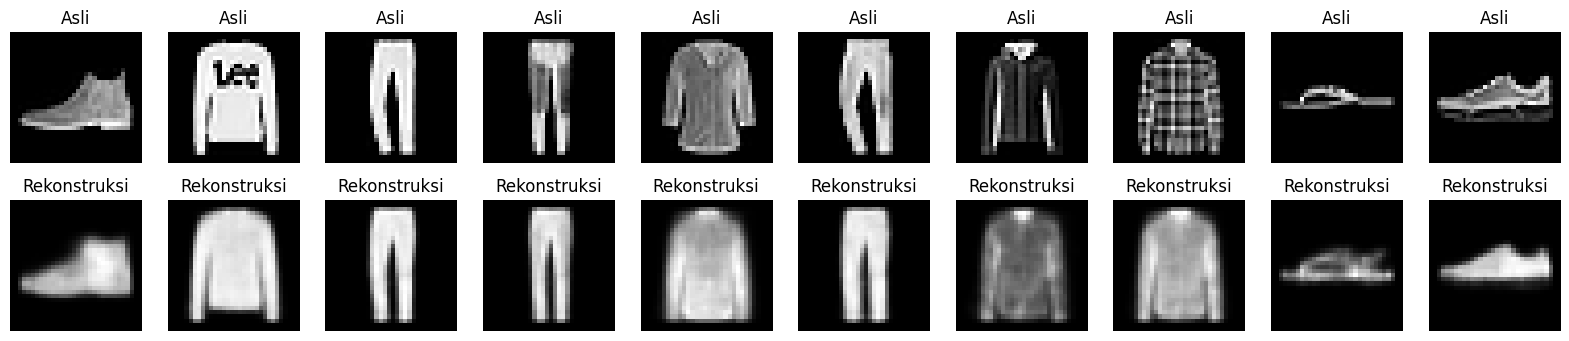


Menampilkan distribusi latent space...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


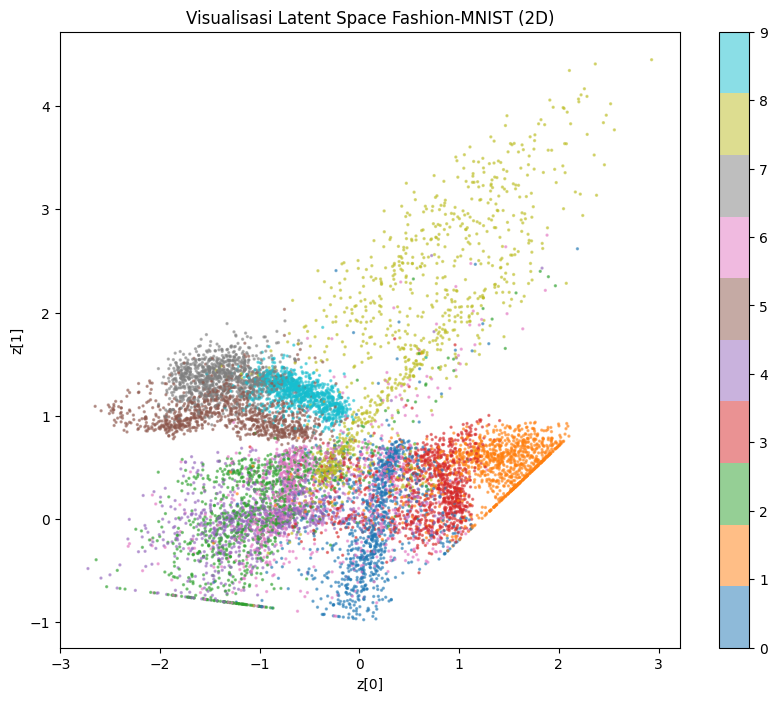


Menampilkan interpolasi grid latent space...


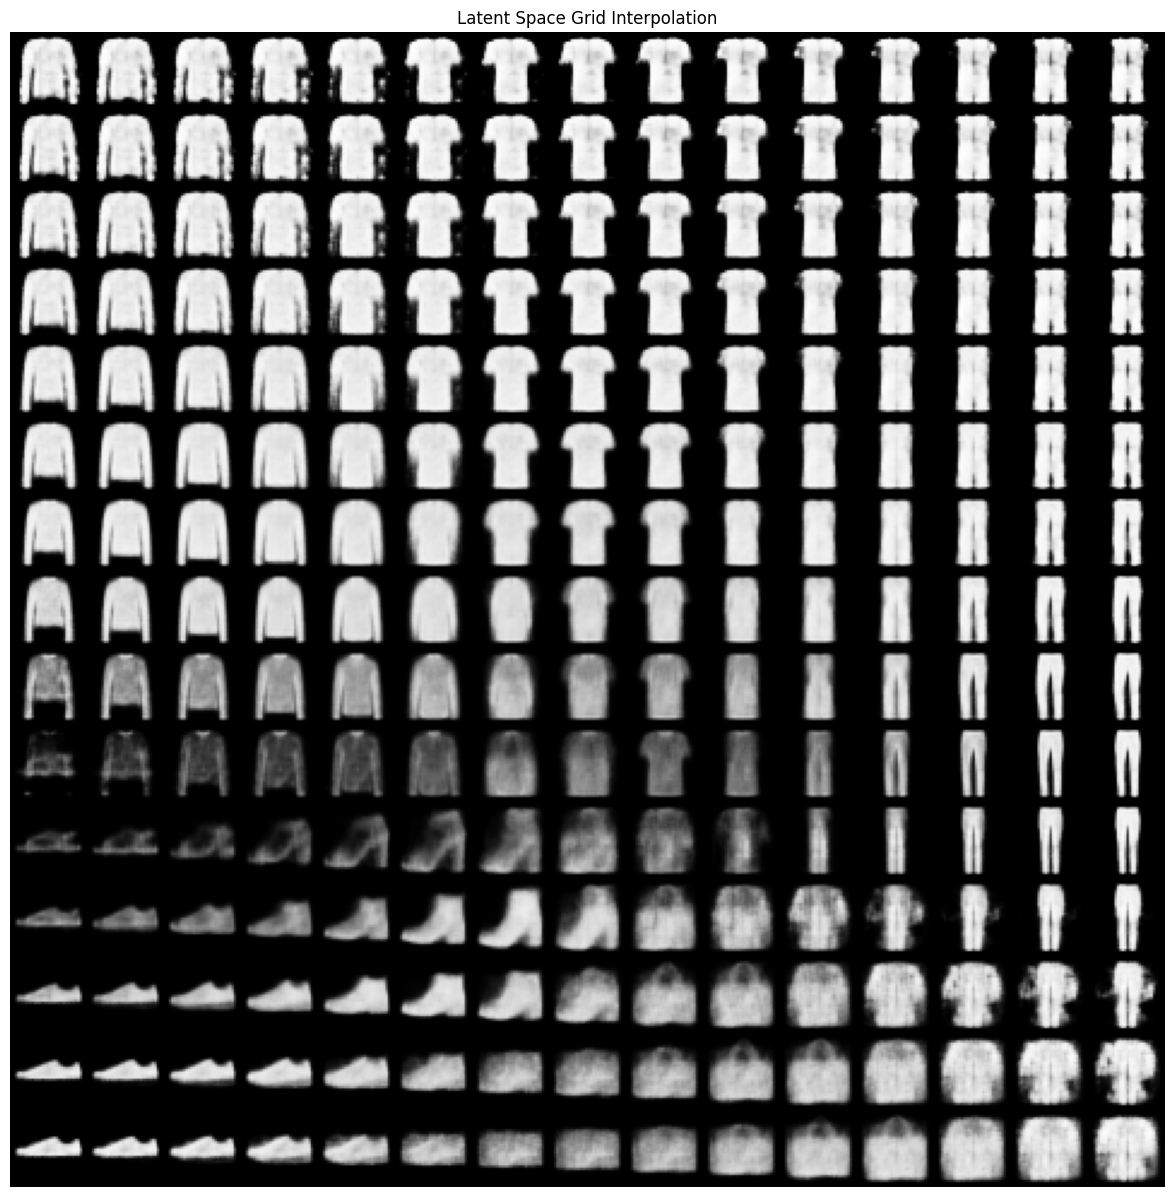

In [ ]:
# ==========================================
# 4. Latihan & Visualisasi
# ==========================================

def plot_latent_space(encoder, x_test, y_test):
    """Latihan 2: Visualisasi distribusi latent space"""
    z_mean, _, _ = encoder.predict(x_test)
    plt.figure(figsize=(10, 8))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='tab10', alpha=0.5, s=2)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Visualisasi Latent Space Fashion-MNIST (2D)")
    plt.show()

def plot_label_grid_interpolation(decoder, n=15, figsize=15):
    """Latihan 3: Latent Space Arithmetic / Grid Interpolation
    Menampilkan grid gambar yang digenerate dari latent space secara kontinu."""

    # Menggunakan asumsi distribusi normal standar, kita ambil rentang dari -3 hingga 3
    scale = 2.0
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    # Ukuran gambar 32x32
    image_size = 32
    figure = np.zeros((image_size * n, image_size * n))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(image_size, image_size)

            figure[
                i * image_size : (i + 1) * image_size,
                j * image_size : (j + 1) * image_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap="Greys_r")
    plt.title("Latent Space Grid Interpolation")
    plt.axis("off")
    plt.show()

def plot_reconstruction_comparison(vae, x_test, n=10):
    """Membandingkan gambar asli dengan hasil rekonstruksi VAE"""
    encoded_imgs = vae.encoder(x_test[:n])
    decoded_imgs = vae.decoder(encoded_imgs[2]) # Menggunakan z

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Gambar Asli
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(32, 32), cmap="gray")
        plt.title("Asli")
        plt.axis("off")

        # Gambar Rekonstruksi
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].numpy().reshape(32, 32), cmap="gray")
        plt.title("Rekonstruksi")
        plt.axis("off")
    plt.show()

# Menjalankan visualisasi
print("\nMenampilkan perbandingan rekonstruksi...")
plot_reconstruction_comparison(vae, x_test)

print("\nMenampilkan distribusi latent space...")
plot_latent_space(encoder, x_test, y_test)

print("\nMenampilkan interpolasi grid latent space...")
plot_label_grid_interpolation(decoder)